In [1]:
%matplotlib inline

import datetime as dt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import statsmodels.api as sm
from pykalman import KalmanFilter
import numpy.ma as ma

pd.set_option('max_rows', 20)
# pd.set_option('max_rows', 1000)

# Data

## Regressors

In [2]:
data = pd.read_excel('Data.xlsx',None,dayFirst=True)

data = list(data.values())

dat=pd.DataFrame()

# del data[6]


for df in data:
    df.set_index("Date", inplace=True)
#     df.drop_duplicates(inplace=True)

In [3]:
data = pd.concat(data,axis=1)
data.sort_index(inplace=True)

### Transformations


In [4]:
data.columns

Index(['GeneralBusinessConditions', 'Imports', 'EmploymentRate',
       'ConsumerPriceIndex', 'NewResidentialSales', 'Exports',
       'UnemploymentRate', 'JoblessClaims', 'IndustrialProductionIndex',
       'DisposableIncome', 'ConsumerConfidence', 'RetailFoodSales',
       'ProducerPriceIndex'],
      dtype='object')

In [5]:
data["IndustrialProductionIndex"] = np.log(data["IndustrialProductionIndex"]) - np.log(data["IndustrialProductionIndex"].shift(1))
data["ConsumerConfidence"] = np.log(data["ConsumerConfidence"]) - np.log(data["ConsumerConfidence"].shift(1))
data["Imports"] = np.log(data["Imports"]) - np.log(data["Imports"].shift(1))
data["Exports"] = np.log(data["Exports"]) - np.log(data["Exports"].shift(1))
data["ProducerPriceIndex"] = np.log(data["ProducerPriceIndex"]) - np.log(data["ProducerPriceIndex"].shift(1))
data["JoblessClaims"] = np.log(data["JoblessClaims"]) - np.log(data["JoblessClaims"].shift(1))
data["RetailFoodSales"] = np.log(data["RetailFoodSales"]) - np.log(data["RetailFoodSales"].shift(1))
data["NewResidentialSales"] = np.log(data["NewResidentialSales"]) - np.log(data["NewResidentialSales"].shift(1))
data["UnemploymentRate"] = data["UnemploymentRate"] - data["UnemploymentRate"].shift(1)
data["EmploymentRate"] = data["EmploymentRate"] - data["EmploymentRate"].shift(1)
data["DisposableIncome"] = np.log(data["DisposableIncome"]) - np.log(data["DisposableIncome"].shift(1))
data["GeneralBusinessConditions"] = np.log(data["GeneralBusinessConditions"]) - np.log(data["GeneralBusinessConditions"].shift(1))
data["ConsumerPriceIndex"] = data["ConsumerPriceIndex"]

# data["ConsumerPriceIndex"].loc[dt.datetime(2009,1,1):].plot()

### Stationarity

In [6]:
for series in data.columns:
    d = data[series]    
    pv = sm.tsa.stattools.adfuller(d[d.notnull()])[1]
    if pv > 0.05:
        print(series + " 's p-value is: " + str(pv))

EmploymentRate 's p-value is: 0.345649514846
NewResidentialSales 's p-value is: 0.988370553646
JoblessClaims 's p-value is: 0.24770534847
RetailFoodSales 's p-value is: 0.627133470279


## Response Variable

In [7]:
gdp = pd.read_excel('GDP.xlsx',dayFirst=True)
gdp.set_index("Date", inplace=True)
gdp["GDP"] = np.log(gdp["GDP"]) - np.log(gdp["GDP"].shift(1))

# Balanced Panel

In [8]:
balancedIndex = ~data.isnull().any(axis=1)
data[balancedIndex]

,GeneralBusinessConditions,Imports,EmploymentRate,ConsumerPriceIndex,NewResidentialSales,Exports,UnemploymentRate,JoblessClaims,IndustrialProductionIndex,DisposableIncome,ConsumerConfidence,RetailFoodSales,ProducerPriceIndex
Date,,,,,,,,,,,,,
2010-01-31,0.020834,-0.067987,-0.004,0.75,0.013766,-0.246317,-0.001,-0.188285,-0.069069,0.008873,0.016840,-0.236325,0.014889
2010-02-28,0.051153,0.027679,-0.002,0.78,0.035409,0.075958,0.004,0.069042,-0.001136,0.004470,-0.067030,-0.048187,0.012143
2010-03-31,0.029827,0.242947,-0.002,0.52,0.046870,0.254201,0.009,0.165317,0.180426,-0.018580,0.035091,0.231714,-0.001559
2010-04-30,0.002590,-0.081357,0.003,0.57,0.030556,-0.036670,0.002,-0.136788,-0.083052,0.007699,0.003038,-0.160867,0.003989
2010-05-31,-0.007789,0.026540,-0.001,0.43,0.036153,0.154966,0.000,0.029296,0.039419,0.004203,0.023977,0.055060,0.004650
2010-06-30,0.000868,0.039556,0.004,0.00,0.032330,-0.034984,-0.004,0.010577,-0.031205,0.009207,0.015671,-0.011223,0.001063
2010-07-31,0.001735,0.096491,0.001,0.01,0.040110,0.033311,-0.003,0.015757,0.045962,0.024352,-0.007805,0.043077,0.000869
2010-08-31,0.002596,0.031145,0.002,0.04,0.038008,0.084763,-0.003,0.006069,0.043942,0.027146,0.034652,0.039221,0.007304
2010-09-30,0.007749,0.052935,0.005,0.45,0.034327,-0.021197,-0.008,0.000323,0.000000,0.020778,0.013158,-0.019948,0.005824


# Step #1: PCA to retrieve factors from balanced panel

In [9]:
n_components=5
pca = PCA(n_components=n_components)
components = pca.fit_transform(data[balancedIndex])
components = pd.DataFrame(components)
components.set_index(data[balancedIndex].index, inplace=True)

print(pca.explained_variance_ratio_) 

[ 0.6241585   0.22421535  0.08139473  0.02986808  0.01642318]


In [10]:
sum(pca.explained_variance_ratio_)

0.97605984190422546

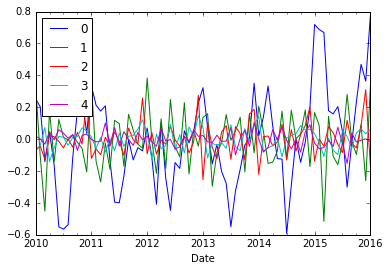

In [11]:
pd.DataFrame(components).plot()

# Step #2: OLS to estimate parameters

Since we have $F_t$ we can now estimate $\Lambda$ from equation

$$x_{t|v_{\nu}} = \mu + \Lambda F_t + \xi_{t|v_{\nu}}$$

OLS Estimator can be obtained by:



## OLS

first I need to match the estimated components to the available GDPs

We won't use a constant since we expect at least one of the factors to have little variance

In [12]:
olsSample = gdp.join(components, how="inner")
gdpComp = olsSample[list(range(0,n_components))]

In [13]:
# X = sm.add_constant(gdpComp)
X = gdpComp
model = sm.OLS(olsSample["GDP"],X)
results = model.fit()
results.params
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    GDP   R-squared:                       0.767
Model:                            OLS   Adj. R-squared:                  0.706
Method:                 Least Squares   F-statistic:                     12.54
Date:                Sat, 03 Dec 2016   Prob (F-statistic):           1.78e-05
Time:                        22:25:08   Log-Likelihood:                 60.826
No. Observations:                  24   AIC:                            -111.7
Df Residuals:                      19   BIC:                            -105.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0505      0.019     -2.632      0.0

In [14]:
results.params

0   -0.050517
1    0.022236
2    0.177091
3   -0.069884
4    0.299148
dtype: float64

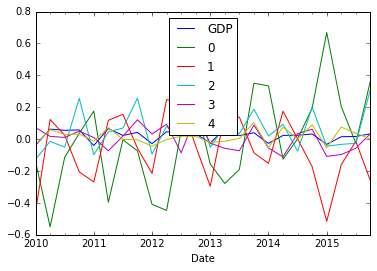

In [15]:
olsSample.plot()

In [16]:
model = sm.tsa.ARMA(olsSample["GDP"],order=(1,0,0))
results = model.fit()
results.params
print(results.summary())

                              ARMA Model Results                              
Dep. Variable:                    GDP   No. Observations:                   24
Model:                     ARMA(1, 0)   Log Likelihood                  49.239
Method:                       css-mle   S.D. of innovations              0.031
Date:                Sat, 03 Dec 2016   AIC                            -92.477
Time:                        22:25:09   BIC                            -88.943
Sample:                    03-31-2010   HQIC                           -91.540
                         - 12-31-2015                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0218      0.005      4.767      0.000       0.013       0.031
ar.L1.GDP     -0.4019      0.196     -2.053      0.052      -0.786      -0.018
                                    Roots           

# pykalman

## Convergence

In [17]:
kf = KalmanFilter(initial_state_mean=0, n_dim_obs=2, n_dim_state=1)
# measurements = [[1,0], [0,0], [0,1]]
measurements = pd.DataFrame([[1,0], [0,0], [0,1]])
kf.em(measurements).smooth([[2,0], [2,1], [2,2]])[0]

array([[ 0.85819709],
       [ 1.77811829],
       [ 2.19537816]])

In [18]:
n_dim_state = 5
obs = data[balancedIndex]
initial_means = np.zeros((n_dim_state))
n_dim_obs = data.shape[1]

In [19]:
kf = KalmanFilter(initial_state_mean=initial_means, n_dim_obs=n_dim_obs, n_dim_state=n_dim_state, em_vars='all')
components = kf.em(obs, n_iter=1).smooth(obs)
# pd.DataFrame(components[0], index=obs.index).plot()
kf.observation_matrices[0][0]

0.0013146534068194016

In [20]:
lst = []
last_matrix = np.zeros((13,5))
for i in range(0,10):
    kf = KalmanFilter(initial_state_mean=initial_means, n_dim_obs=n_dim_obs, n_dim_state=n_dim_state, em_vars='all')
    components = kf.em(obs, n_iter=1+i*10).smooth(obs)
    lst.append(np.linalg.norm(kf.observation_matrices-last_matrix))
    last_matrix = kf.observation_matrices
    print(i)
    

0
1
2
3
4


KeyboardInterrupt: 

In [ ]:
pd.DataFrame(lst).plot()

## Missing Data

In [47]:
kf = KalmanFilter(initial_state_mean=0, n_dim_obs=2,n_dim_state=1,em_vars='all')

measurements1 = pd.DataFrame([[1,0], [1,0], [0,1]])
measurements = pd.DataFrame([[1,0], [1,0], [0,1],[2,0]])
measurements = ma.array(measurements)
measurements.mask = measurements==7

# measurements = measurements.mask(measurements==nA)
# measurements = [[1,0], [0,0], [0,1]]
kf.em(measurements1).smooth(measurements)

(array([[  0.88378619],
        [  2.44267351],
        [ 10.15335524],
        [ 48.54044943]]), array([[[ 0.00528544]],
 
        [[ 0.00706399]],
 
        [[ 0.00715135]],
 
        [[ 0.00747876]]]))

In [48]:
kf = KalmanFilter(initial_state_mean=0, n_dim_obs=2,n_dim_state=1,em_vars='all')

measurements1 = pd.DataFrame([[1,0], [1,0], [0,1]])
measurements = pd.DataFrame([[1,0], [7,0], [0,1],[2,0]])
measurements = ma.array(measurements)
measurements.mask = measurements==7

# measurements = measurements.mask(measurements==nA)
# measurements = [[1,0], [0,0], [0,1]]
kf.em(measurements1).smooth(measurements)

(array([[  1.15540458],
        [  4.22343839],
        [ 10.51702997],
        [ 48.61794124]]), array([[[ 0.00543859]],
 
        [[ 0.01364673]],
 
        [[ 0.0074259 ]],
 
        [[ 0.00749122]]]))

In [51]:
kf = KalmanFilter(initial_state_mean=0, n_dim_obs=2,n_dim_state=1,em_vars='all')

measurements1 = pd.DataFrame([[1,0], [1,0], [0,1]])
measurements = pd.DataFrame([[1,0], [1,7], [0,1],[2,0]])
measurements = ma.array(measurements)
measurements.mask = measurements==7

# measurements = measurements.mask(measurements==nA)
# measurements = [[1,0], [0,0], [0,1]]
kf.em(measurements1).smooth(measurements)

(array([[  1.15540458],
        [  4.22343839],
        [ 10.51702997],
        [ 48.61794124]]), array([[[ 0.00543859]],
 
        [[ 0.01364673]],
 
        [[ 0.0074259 ]],
 
        [[ 0.00749122]]]))

In [73]:
kf = KalmanFilter(initial_state_mean=0, n_dim_obs=2,n_dim_state=1,em_vars='all')

measurements = pd.DataFrame([[1,0], [1,0], [0,1]])

# measurements = measurements.mask(measurements==nA)
# measurements = [[1,0], [0,0], [0,1]]
kf.em(measurements).smooth(measurements)
# kf.em(measurements,n_iter=1).observation_matrices

(array([[ 0.58132112],
        [ 0.45967388],
        [ 0.32335319]]), array([[[ 0.00528575]],
 
        [[ 0.00707718]],
 
        [[ 0.00747539]]]))

# Statsmodels trial

Main reference [this example](http://www.statsmodels.org/dev/examples/notebooks/generated/statespace_dfm_coincident.html)

In [ ]:
#useful

# res.summary()
# res.summary(separate_params=False)
# res.factors
# res.plot_coefficients_of_determination(figsize=(8,2));

In [67]:
factorModel = sm.tsa.DynamicFactor(endog=obs,k_factors=5,factor_order=1,error_cov_type='diagonal')

In [68]:
factorModel.fit(maxiter=3000, full_output=True)

/Users/mac/anaconda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [117]:
measurements = pd.DataFrame([[1,0], [7,1], [0,1],[2,0]])
measurements = ma.array(measurements)
measurements.mask = measurements==7

factorModel = sm.tsa.DynamicFactor(endog=measurements,k_factors=1,factor_order=1)
res = factorModel.fit(maxiter=500)
res.factors

{'filtered': array([[ 0.07173695,  1.73358334,  1.39180906,  0.25812806]]),
 'filtered_cov': array([[[ 0.19304429,  0.18623082,  0.18618044,  0.18618007]]]),
 'offset': 0,
 'smoothed': array([[ 0.22707218,  1.77837415,  1.35627852,  0.25812806]]),
 'smoothed_cov': array([[[ 0.18618007,  0.17983492,  0.17983492,  0.18618007]]])}

In [124]:

measurements = pd.DataFrame([[1,0], [np.nan,1], [0,1],[2,0]])


factorModel = sm.tsa.DynamicFactor(endog=np.array(measurements),k_factors=1,factor_order=1)
res = factorModel.fit(maxiter=500)
res.factors

LinAlgError: Array must not contain infs or NaNs

In [121]:
measurements = pd.DataFrame([[1,0], [np.nan,1], [0,1],[2,0]])

In [123]:
np.array(measurements)

array([[  1.,   0.],
       [ nan,   1.],
       [  0.,   1.],
       [  2.,   0.]])